# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.002581467
Average power, source: 7.177694e-06


Average magnitude, target: 0.0015976364
Average power, target: 2.722644e-06


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2520], examples_per_second: 83.5913, train_label_loss: 2.7385, 


epoch: 1, [batch: 252 / 2520], examples_per_second: 4136.9550, train_label_loss: 0.6107, 


epoch: 1, [batch: 504 / 2520], examples_per_second: 4225.4202, train_label_loss: 0.1886, 


epoch: 1, [batch: 756 / 2520], examples_per_second: 4429.0630, train_label_loss: 0.1036, 


epoch: 1, [batch: 1008 / 2520], examples_per_second: 4162.0272, train_label_loss: 0.0620, 


epoch: 1, [batch: 1260 / 2520], examples_per_second: 4253.2597, train_label_loss: 0.1041, 


epoch: 1, [batch: 1512 / 2520], examples_per_second: 4437.4517, train_label_loss: 0.2279, 


epoch: 1, [batch: 1764 / 2520], examples_per_second: 4278.5078, train_label_loss: 0.1293, 


epoch: 1, [batch: 2016 / 2520], examples_per_second: 4321.6018, train_label_loss: 0.3008, 


epoch: 1, [batch: 2268 / 2520], examples_per_second: 4381.2039, train_label_loss: 0.2849, 


epoch: 1, source_val_acc_label: 0.6735, target_val_acc_label: 0.4931, source_val_label_loss: 66.5240, target_val_label_loss: 129.2880, 


New best


epoch: 2, [batch: 1 / 2520], examples_per_second: 11.2835, train_label_loss: 222.3405, 


epoch: 2, [batch: 252 / 2520], examples_per_second: 3790.0738, train_label_loss: 7.0853, 


epoch: 2, [batch: 504 / 2520], examples_per_second: 3896.9826, train_label_loss: 0.1711, 


epoch: 2, [batch: 756 / 2520], examples_per_second: 4000.7164, train_label_loss: 0.2514, 


epoch: 2, [batch: 1008 / 2520], examples_per_second: 3996.8100, train_label_loss: 1.7698, 


epoch: 2, [batch: 1260 / 2520], examples_per_second: 4034.8619, train_label_loss: 1.2074, 


epoch: 2, [batch: 1512 / 2520], examples_per_second: 3981.2994, train_label_loss: 0.1890, 


epoch: 2, [batch: 1764 / 2520], examples_per_second: 3920.3305, train_label_loss: 0.0046, 


epoch: 2, [batch: 2016 / 2520], examples_per_second: 3948.8080, train_label_loss: 0.9749, 


epoch: 2, [batch: 2268 / 2520], examples_per_second: 3915.8706, train_label_loss: 0.0473, 


epoch: 2, source_val_acc_label: 0.9457, target_val_acc_label: 0.8083, source_val_label_loss: 0.1748, target_val_label_loss: 6.1051, 


New best


epoch: 3, [batch: 1 / 2520], examples_per_second: 8.5404, train_label_loss: 0.1507, 


epoch: 3, [batch: 252 / 2520], examples_per_second: 3890.2458, train_label_loss: 0.7285, 


epoch: 3, [batch: 504 / 2520], examples_per_second: 3895.9252, train_label_loss: 0.6036, 


epoch: 3, [batch: 756 / 2520], examples_per_second: 4036.6974, train_label_loss: 0.1493, 


epoch: 3, [batch: 1008 / 2520], examples_per_second: 3855.6834, train_label_loss: 0.2537, 


epoch: 3, [batch: 1260 / 2520], examples_per_second: 3879.5804, train_label_loss: 0.3697, 


epoch: 3, [batch: 1512 / 2520], examples_per_second: 3901.8928, train_label_loss: 0.5540, 


epoch: 3, [batch: 1764 / 2520], examples_per_second: 3797.4798, train_label_loss: 0.0121, 


epoch: 3, [batch: 2016 / 2520], examples_per_second: 3859.5213, train_label_loss: 0.0961, 


epoch: 3, [batch: 2268 / 2520], examples_per_second: 3947.7515, train_label_loss: 0.0099, 


epoch: 3, source_val_acc_label: 0.9543, target_val_acc_label: 0.8010, source_val_label_loss: 0.1325, target_val_label_loss: 5.3389, 


epoch: 4, [batch: 1 / 2520], examples_per_second: 8.6352, train_label_loss: 0.1704, 


epoch: 4, [batch: 252 / 2520], examples_per_second: 3848.2798, train_label_loss: 0.1719, 


epoch: 4, [batch: 504 / 2520], examples_per_second: 3859.7391, train_label_loss: 0.0617, 


epoch: 4, [batch: 756 / 2520], examples_per_second: 3890.0915, train_label_loss: 0.1565, 


epoch: 4, [batch: 1008 / 2520], examples_per_second: 3961.2614, train_label_loss: 0.3933, 


epoch: 4, [batch: 1260 / 2520], examples_per_second: 4062.6991, train_label_loss: 0.0122, 


epoch: 4, [batch: 1512 / 2520], examples_per_second: 4014.2036, train_label_loss: 0.0158, 


epoch: 4, [batch: 1764 / 2520], examples_per_second: 3972.0782, train_label_loss: 0.0265, 


epoch: 4, [batch: 2016 / 2520], examples_per_second: 3929.6066, train_label_loss: 0.0365, 


epoch: 4, [batch: 2268 / 2520], examples_per_second: 3899.4017, train_label_loss: 0.0385, 


epoch: 4, source_val_acc_label: 0.9601, target_val_acc_label: 0.8090, source_val_label_loss: 0.1239, target_val_label_loss: 4.7447, 


New best


epoch: 5, [batch: 1 / 2520], examples_per_second: 8.8397, train_label_loss: 0.0178, 


epoch: 5, [batch: 252 / 2520], examples_per_second: 3935.5758, train_label_loss: 0.0516, 


epoch: 5, [batch: 504 / 2520], examples_per_second: 3851.4808, train_label_loss: 0.2687, 


epoch: 5, [batch: 756 / 2520], examples_per_second: 3877.1648, train_label_loss: 0.3823, 


epoch: 5, [batch: 1008 / 2520], examples_per_second: 3919.9804, train_label_loss: 0.0827, 


epoch: 5, [batch: 1260 / 2520], examples_per_second: 3863.9119, train_label_loss: 0.0137, 


epoch: 5, [batch: 1512 / 2520], examples_per_second: 4083.2523, train_label_loss: 0.0090, 


epoch: 5, [batch: 1764 / 2520], examples_per_second: 4039.2750, train_label_loss: 0.1650, 


epoch: 5, [batch: 2016 / 2520], examples_per_second: 4046.4192, train_label_loss: 0.2171, 


epoch: 5, [batch: 2268 / 2520], examples_per_second: 4018.5076, train_label_loss: 0.1287, 


epoch: 5, source_val_acc_label: 0.9597, target_val_acc_label: 0.8039, source_val_label_loss: 0.1242, target_val_label_loss: 4.8665, 


epoch: 6, [batch: 1 / 2520], examples_per_second: 9.2612, train_label_loss: 0.0101, 


epoch: 6, [batch: 252 / 2520], examples_per_second: 4145.0981, train_label_loss: 0.0266, 


epoch: 6, [batch: 504 / 2520], examples_per_second: 4581.0247, train_label_loss: 0.2422, 


epoch: 6, [batch: 756 / 2520], examples_per_second: 4216.1432, train_label_loss: 0.0279, 


epoch: 6, [batch: 1008 / 2520], examples_per_second: 4161.8183, train_label_loss: 0.0092, 


epoch: 6, [batch: 1260 / 2520], examples_per_second: 4249.1919, train_label_loss: 0.1340, 


epoch: 6, [batch: 1512 / 2520], examples_per_second: 4300.8385, train_label_loss: 0.0306, 


epoch: 6, [batch: 1764 / 2520], examples_per_second: 4233.9793, train_label_loss: 0.1794, 


epoch: 6, [batch: 2016 / 2520], examples_per_second: 4516.7712, train_label_loss: 0.0307, 


epoch: 6, [batch: 2268 / 2520], examples_per_second: 4863.9752, train_label_loss: 0.0178, 


epoch: 6, source_val_acc_label: 0.9659, target_val_acc_label: 0.8137, source_val_label_loss: 0.1031, target_val_label_loss: 4.5219, 


New best


epoch: 7, [batch: 1 / 2520], examples_per_second: 10.1646, train_label_loss: 0.0450, 


epoch: 7, [batch: 252 / 2520], examples_per_second: 3890.2823, train_label_loss: 0.0122, 


epoch: 7, [batch: 504 / 2520], examples_per_second: 3835.5990, train_label_loss: 0.1677, 


epoch: 7, [batch: 756 / 2520], examples_per_second: 3896.3808, train_label_loss: 0.0873, 


epoch: 7, [batch: 1008 / 2520], examples_per_second: 3897.8010, train_label_loss: 0.0168, 


epoch: 7, [batch: 1260 / 2520], examples_per_second: 4025.3216, train_label_loss: 0.0117, 


epoch: 7, [batch: 1512 / 2520], examples_per_second: 4025.2629, train_label_loss: 0.0006, 


epoch: 7, [batch: 1764 / 2520], examples_per_second: 3967.0849, train_label_loss: 0.1748, 


epoch: 7, [batch: 2016 / 2520], examples_per_second: 3995.0037, train_label_loss: 0.0322, 


epoch: 7, [batch: 2268 / 2520], examples_per_second: 4045.2061, train_label_loss: 0.1629, 


epoch: 7, source_val_acc_label: 0.9567, target_val_acc_label: 0.8014, source_val_label_loss: 0.1290, target_val_label_loss: 5.2308, 


epoch: 8, [batch: 1 / 2520], examples_per_second: 8.5921, train_label_loss: 0.0277, 


epoch: 8, [batch: 252 / 2520], examples_per_second: 3895.7043, train_label_loss: 0.0129, 


epoch: 8, [batch: 504 / 2520], examples_per_second: 3861.7502, train_label_loss: 0.3786, 


epoch: 8, [batch: 756 / 2520], examples_per_second: 3859.3882, train_label_loss: 0.1251, 


epoch: 8, [batch: 1008 / 2520], examples_per_second: 3791.7197, train_label_loss: 0.0271, 


epoch: 8, [batch: 1260 / 2520], examples_per_second: 3849.8310, train_label_loss: 0.0049, 


epoch: 8, [batch: 1512 / 2520], examples_per_second: 3841.6836, train_label_loss: 0.0375, 


epoch: 8, [batch: 1764 / 2520], examples_per_second: 3847.4543, train_label_loss: 0.0485, 


epoch: 8, [batch: 2016 / 2520], examples_per_second: 3858.8932, train_label_loss: 0.1013, 


epoch: 8, [batch: 2268 / 2520], examples_per_second: 3876.0544, train_label_loss: 0.1326, 


epoch: 8, source_val_acc_label: 0.9642, target_val_acc_label: 0.8105, source_val_label_loss: 0.1015, target_val_label_loss: 4.6233, 


epoch: 9, [batch: 1 / 2520], examples_per_second: 8.4819, train_label_loss: 0.0018, 


epoch: 9, [batch: 252 / 2520], examples_per_second: 3943.1108, train_label_loss: 0.1236, 


epoch: 9, [batch: 504 / 2520], examples_per_second: 4052.4290, train_label_loss: 0.1413, 


epoch: 9, [batch: 756 / 2520], examples_per_second: 3999.1359, train_label_loss: 0.3246, 


epoch: 9, [batch: 1008 / 2520], examples_per_second: 3964.2636, train_label_loss: 0.0230, 


epoch: 9, [batch: 1260 / 2520], examples_per_second: 4008.0482, train_label_loss: 0.0109, 


epoch: 9, [batch: 1512 / 2520], examples_per_second: 4019.2579, train_label_loss: 0.0051, 


epoch: 9, [batch: 1764 / 2520], examples_per_second: 3945.5706, train_label_loss: 0.0080, 


epoch: 9, [batch: 2016 / 2520], examples_per_second: 4154.8404, train_label_loss: 0.1981, 


epoch: 9, [batch: 2268 / 2520], examples_per_second: 3952.5883, train_label_loss: 0.0531, 


epoch: 9, source_val_acc_label: 0.9742, target_val_acc_label: 0.8181, source_val_label_loss: 0.0893, target_val_label_loss: 5.0725, 


New best


epoch: 10, [batch: 1 / 2520], examples_per_second: 8.6171, train_label_loss: 0.0030, 


epoch: 10, [batch: 252 / 2520], examples_per_second: 3885.2401, train_label_loss: 0.1024, 


epoch: 10, [batch: 504 / 2520], examples_per_second: 3846.7736, train_label_loss: 0.1110, 


epoch: 10, [batch: 756 / 2520], examples_per_second: 3863.5899, train_label_loss: 0.0012, 


epoch: 10, [batch: 1008 / 2520], examples_per_second: 3846.2707, train_label_loss: 0.0153, 


epoch: 10, [batch: 1260 / 2520], examples_per_second: 3904.0852, train_label_loss: 0.0032, 


epoch: 10, [batch: 1512 / 2520], examples_per_second: 3923.4902, train_label_loss: 0.2053, 


epoch: 10, [batch: 1764 / 2520], examples_per_second: 3819.8196, train_label_loss: 0.0131, 


epoch: 10, [batch: 2016 / 2520], examples_per_second: 3838.7961, train_label_loss: 0.0835, 


epoch: 10, [batch: 2268 / 2520], examples_per_second: 3870.9284, train_label_loss: 0.0961, 


epoch: 10, source_val_acc_label: 0.9654, target_val_acc_label: 0.8185, source_val_label_loss: 0.0946, target_val_label_loss: 4.6267, 


New best


epoch: 11, [batch: 1 / 2520], examples_per_second: 9.1896, train_label_loss: 0.0133, 


epoch: 11, [batch: 252 / 2520], examples_per_second: 4477.3085, train_label_loss: 0.0019, 


epoch: 11, [batch: 504 / 2520], examples_per_second: 4192.5118, train_label_loss: 0.0049, 


epoch: 11, [batch: 756 / 2520], examples_per_second: 4340.3860, train_label_loss: 0.0077, 


epoch: 11, [batch: 1008 / 2520], examples_per_second: 4321.1077, train_label_loss: 0.0010, 


epoch: 11, [batch: 1260 / 2520], examples_per_second: 4322.5705, train_label_loss: 0.0403, 


epoch: 11, [batch: 1512 / 2520], examples_per_second: 4337.9816, train_label_loss: 0.0018, 


epoch: 11, [batch: 1764 / 2520], examples_per_second: 4318.9622, train_label_loss: 0.0452, 


epoch: 11, [batch: 2016 / 2520], examples_per_second: 4914.2299, train_label_loss: 0.1485, 


epoch: 11, [batch: 2268 / 2520], examples_per_second: 4285.3338, train_label_loss: 0.0399, 


epoch: 11, source_val_acc_label: 0.9622, target_val_acc_label: 0.8170, source_val_label_loss: 0.1168, target_val_label_loss: 4.9393, 


epoch: 12, [batch: 1 / 2520], examples_per_second: 9.8235, train_label_loss: 0.1008, 


epoch: 12, [batch: 252 / 2520], examples_per_second: 4222.3238, train_label_loss: 0.1173, 


epoch: 12, [batch: 504 / 2520], examples_per_second: 4395.2022, train_label_loss: 0.0130, 


epoch: 12, [batch: 756 / 2520], examples_per_second: 4396.4824, train_label_loss: 0.0506, 


epoch: 12, [batch: 1008 / 2520], examples_per_second: 4388.7616, train_label_loss: 0.0067, 


epoch: 12, [batch: 1260 / 2520], examples_per_second: 4270.2285, train_label_loss: 0.0046, 


epoch: 12, [batch: 1512 / 2520], examples_per_second: 4359.0785, train_label_loss: 0.1318, 


epoch: 12, [batch: 1764 / 2520], examples_per_second: 4846.0165, train_label_loss: 0.3034, 


epoch: 12, [batch: 2016 / 2520], examples_per_second: 4400.5320, train_label_loss: 0.0737, 


epoch: 12, [batch: 2268 / 2520], examples_per_second: 4385.1600, train_label_loss: 0.0087, 


epoch: 12, source_val_acc_label: 0.9648, target_val_acc_label: 0.8129, source_val_label_loss: 0.0999, target_val_label_loss: 4.4904, 


epoch: 13, [batch: 1 / 2520], examples_per_second: 9.5779, train_label_loss: 0.0585, 


epoch: 13, [batch: 252 / 2520], examples_per_second: 4194.3180, train_label_loss: 0.0207, 


epoch: 13, [batch: 504 / 2520], examples_per_second: 4279.8609, train_label_loss: 0.0030, 


epoch: 13, [batch: 756 / 2520], examples_per_second: 4191.9036, train_label_loss: 0.0310, 


epoch: 13, [batch: 1008 / 2520], examples_per_second: 4261.8437, train_label_loss: 0.0007, 


epoch: 13, [batch: 1260 / 2520], examples_per_second: 4498.7976, train_label_loss: 0.0013, 


epoch: 13, [batch: 1512 / 2520], examples_per_second: 4679.6985, train_label_loss: 0.5301, 


epoch: 13, [batch: 1764 / 2520], examples_per_second: 4206.6025, train_label_loss: 0.0057, 


epoch: 13, [batch: 2016 / 2520], examples_per_second: 4167.6805, train_label_loss: 0.0062, 


epoch: 13, [batch: 2268 / 2520], examples_per_second: 4184.4765, train_label_loss: 0.0021, 


epoch: 13, source_val_acc_label: 0.9736, target_val_acc_label: 0.8313, source_val_label_loss: 0.0770, target_val_label_loss: 4.5026, 


New best


epoch: 14, [batch: 1 / 2520], examples_per_second: 9.3717, train_label_loss: 0.3332, 


epoch: 14, [batch: 252 / 2520], examples_per_second: 4158.3221, train_label_loss: 0.1312, 


epoch: 14, [batch: 504 / 2520], examples_per_second: 4162.7390, train_label_loss: 0.1076, 


epoch: 14, [batch: 756 / 2520], examples_per_second: 4310.3011, train_label_loss: 0.0074, 


epoch: 14, [batch: 1008 / 2520], examples_per_second: 4186.5649, train_label_loss: 0.0834, 


epoch: 14, [batch: 1260 / 2520], examples_per_second: 4175.3348, train_label_loss: 0.0270, 


epoch: 14, [batch: 1512 / 2520], examples_per_second: 4186.0509, train_label_loss: 0.0049, 


epoch: 14, [batch: 1764 / 2520], examples_per_second: 4096.4431, train_label_loss: 0.0011, 


epoch: 14, [batch: 2016 / 2520], examples_per_second: 4132.1455, train_label_loss: 0.0342, 


epoch: 14, [batch: 2268 / 2520], examples_per_second: 4185.1995, train_label_loss: 0.0620, 


epoch: 14, source_val_acc_label: 0.9750, target_val_acc_label: 0.8335, source_val_label_loss: 0.0752, target_val_label_loss: 4.5797, 


New best


epoch: 15, [batch: 1 / 2520], examples_per_second: 10.3471, train_label_loss: 0.0010, 


epoch: 15, [batch: 252 / 2520], examples_per_second: 4909.6749, train_label_loss: 0.0005, 


epoch: 15, [batch: 504 / 2520], examples_per_second: 4939.5844, train_label_loss: 0.0731, 


epoch: 15, [batch: 756 / 2520], examples_per_second: 5034.4156, train_label_loss: 0.0219, 


epoch: 15, [batch: 1008 / 2520], examples_per_second: 5203.6266, train_label_loss: 0.1239, 


epoch: 15, [batch: 1260 / 2520], examples_per_second: 5551.9827, train_label_loss: 0.0005, 


epoch: 15, [batch: 1512 / 2520], examples_per_second: 5382.7021, train_label_loss: 0.3312, 


epoch: 15, [batch: 1764 / 2520], examples_per_second: 5449.2272, train_label_loss: 0.0228, 


epoch: 15, [batch: 2016 / 2520], examples_per_second: 5214.9869, train_label_loss: 0.1983, 


epoch: 15, [batch: 2268 / 2520], examples_per_second: 4921.2915, train_label_loss: 0.0831, 


epoch: 15, source_val_acc_label: 0.9746, target_val_acc_label: 0.8318, source_val_label_loss: 0.0788, target_val_label_loss: 4.8452, 


epoch: 16, [batch: 1 / 2520], examples_per_second: 11.4805, train_label_loss: 0.2113, 


epoch: 16, [batch: 252 / 2520], examples_per_second: 5081.6039, train_label_loss: 0.1916, 


epoch: 16, [batch: 504 / 2520], examples_per_second: 5235.7429, train_label_loss: 0.0009, 


epoch: 16, [batch: 756 / 2520], examples_per_second: 5204.8483, train_label_loss: 0.0867, 


epoch: 16, [batch: 1008 / 2520], examples_per_second: 5309.2949, train_label_loss: 0.0137, 


epoch: 16, [batch: 1260 / 2520], examples_per_second: 5186.7023, train_label_loss: 0.0001, 


epoch: 16, [batch: 1512 / 2520], examples_per_second: 5288.6745, train_label_loss: 0.1382, 


epoch: 16, [batch: 1764 / 2520], examples_per_second: 5299.8651, train_label_loss: 0.0560, 


epoch: 16, [batch: 2016 / 2520], examples_per_second: 5419.0537, train_label_loss: 0.0007, 


epoch: 16, [batch: 2268 / 2520], examples_per_second: 5499.6726, train_label_loss: 0.0002, 


epoch: 16, source_val_acc_label: 0.9720, target_val_acc_label: 0.8315, source_val_label_loss: 0.0878, target_val_label_loss: 4.9123, 


epoch: 17, [batch: 1 / 2520], examples_per_second: 11.6124, train_label_loss: 0.0732, 


epoch: 17, [batch: 252 / 2520], examples_per_second: 4934.3068, train_label_loss: 0.0008, 


epoch: 17, [batch: 504 / 2520], examples_per_second: 4926.0978, train_label_loss: 0.3091, 


epoch: 17, [batch: 756 / 2520], examples_per_second: 4946.1847, train_label_loss: 0.0419, 


epoch: 17, [batch: 1008 / 2520], examples_per_second: 5091.3796, train_label_loss: 0.0398, 


epoch: 17, [batch: 1260 / 2520], examples_per_second: 4826.0401, train_label_loss: 0.0015, 


epoch: 17, [batch: 1512 / 2520], examples_per_second: 4994.7575, train_label_loss: 0.1276, 


epoch: 17, [batch: 1764 / 2520], examples_per_second: 4979.1696, train_label_loss: 0.0006, 


epoch: 17, [batch: 2016 / 2520], examples_per_second: 5082.5894, train_label_loss: 0.0510, 


epoch: 17, [batch: 2268 / 2520], examples_per_second: 4856.3567, train_label_loss: 0.0434, 


epoch: 17, source_val_acc_label: 0.9748, target_val_acc_label: 0.8381, source_val_label_loss: 0.0820, target_val_label_loss: 4.2269, 


New best


epoch: 18, [batch: 1 / 2520], examples_per_second: 11.2978, train_label_loss: 0.0009, 


epoch: 18, [batch: 252 / 2520], examples_per_second: 4952.2422, train_label_loss: 0.1778, 


epoch: 18, [batch: 504 / 2520], examples_per_second: 4941.3025, train_label_loss: 0.0005, 


epoch: 18, [batch: 756 / 2520], examples_per_second: 4989.7581, train_label_loss: 0.2918, 


epoch: 18, [batch: 1008 / 2520], examples_per_second: 4985.9114, train_label_loss: 0.0104, 


epoch: 18, [batch: 1260 / 2520], examples_per_second: 4985.0052, train_label_loss: 0.0032, 


epoch: 18, [batch: 1512 / 2520], examples_per_second: 5071.6161, train_label_loss: 0.0045, 


epoch: 18, [batch: 1764 / 2520], examples_per_second: 5065.9527, train_label_loss: 0.0007, 


epoch: 18, [batch: 2016 / 2520], examples_per_second: 5184.3147, train_label_loss: 0.0389, 


epoch: 18, [batch: 2268 / 2520], examples_per_second: 4926.3969, train_label_loss: 0.3297, 


epoch: 18, source_val_acc_label: 0.9740, target_val_acc_label: 0.8321, source_val_label_loss: 0.0876, target_val_label_loss: 4.6769, 


epoch: 19, [batch: 1 / 2520], examples_per_second: 11.5268, train_label_loss: 0.1675, 


epoch: 19, [batch: 252 / 2520], examples_per_second: 5397.4966, train_label_loss: 0.1966, 


epoch: 19, [batch: 504 / 2520], examples_per_second: 5270.0107, train_label_loss: 0.0145, 


epoch: 19, [batch: 756 / 2520], examples_per_second: 5250.7239, train_label_loss: 0.0237, 


epoch: 19, [batch: 1008 / 2520], examples_per_second: 5182.8152, train_label_loss: 0.0789, 


epoch: 19, [batch: 1260 / 2520], examples_per_second: 4925.0658, train_label_loss: 0.2849, 


epoch: 19, [batch: 1512 / 2520], examples_per_second: 5185.2955, train_label_loss: 0.0062, 


epoch: 19, [batch: 1764 / 2520], examples_per_second: 5010.1726, train_label_loss: 0.0007, 


epoch: 19, [batch: 2016 / 2520], examples_per_second: 5312.9585, train_label_loss: 0.0015, 


epoch: 19, [batch: 2268 / 2520], examples_per_second: 4386.8345, train_label_loss: 0.0398, 


epoch: 19, source_val_acc_label: 0.9733, target_val_acc_label: 0.8272, source_val_label_loss: 0.0836, target_val_label_loss: 5.2649, 


epoch: 20, [batch: 1 / 2520], examples_per_second: 8.6048, train_label_loss: 0.0282, 


epoch: 20, [batch: 252 / 2520], examples_per_second: 3926.1322, train_label_loss: 0.0073, 


epoch: 20, [batch: 504 / 2520], examples_per_second: 3907.0048, train_label_loss: 0.0018, 


epoch: 20, [batch: 756 / 2520], examples_per_second: 3875.8076, train_label_loss: 0.0403, 


epoch: 20, [batch: 1008 / 2520], examples_per_second: 3907.0148, train_label_loss: 0.0010, 


epoch: 20, [batch: 1260 / 2520], examples_per_second: 3870.6738, train_label_loss: 0.0513, 


epoch: 20, [batch: 1512 / 2520], examples_per_second: 4101.8934, train_label_loss: 0.0976, 


epoch: 20, [batch: 1764 / 2520], examples_per_second: 4317.2640, train_label_loss: 0.0018, 


epoch: 20, [batch: 2016 / 2520], examples_per_second: 4356.6820, train_label_loss: 0.0043, 


epoch: 20, [batch: 2268 / 2520], examples_per_second: 4339.1465, train_label_loss: 0.0143, 


epoch: 20, source_val_acc_label: 0.9711, target_val_acc_label: 0.8273, source_val_label_loss: 0.0956, target_val_label_loss: 4.0447, 


epoch: 21, [batch: 1 / 2520], examples_per_second: 8.4880, train_label_loss: 0.0383, 


epoch: 21, [batch: 252 / 2520], examples_per_second: 4103.6119, train_label_loss: 0.1737, 


epoch: 21, [batch: 504 / 2520], examples_per_second: 3938.2188, train_label_loss: 0.0036, 


epoch: 21, [batch: 756 / 2520], examples_per_second: 3920.3923, train_label_loss: 0.0121, 


epoch: 21, [batch: 1008 / 2520], examples_per_second: 3907.7482, train_label_loss: 0.0446, 


epoch: 21, [batch: 1260 / 2520], examples_per_second: 3913.5852, train_label_loss: 0.0001, 


epoch: 21, [batch: 1512 / 2520], examples_per_second: 4224.8590, train_label_loss: 0.0006, 


epoch: 21, [batch: 1764 / 2520], examples_per_second: 4548.8166, train_label_loss: 0.0378, 


epoch: 21, [batch: 2016 / 2520], examples_per_second: 4487.0521, train_label_loss: 0.2911, 


epoch: 21, [batch: 2268 / 2520], examples_per_second: 4681.5264, train_label_loss: 0.0486, 


epoch: 21, source_val_acc_label: 0.9701, target_val_acc_label: 0.8314, source_val_label_loss: 0.0944, target_val_label_loss: 4.6194, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

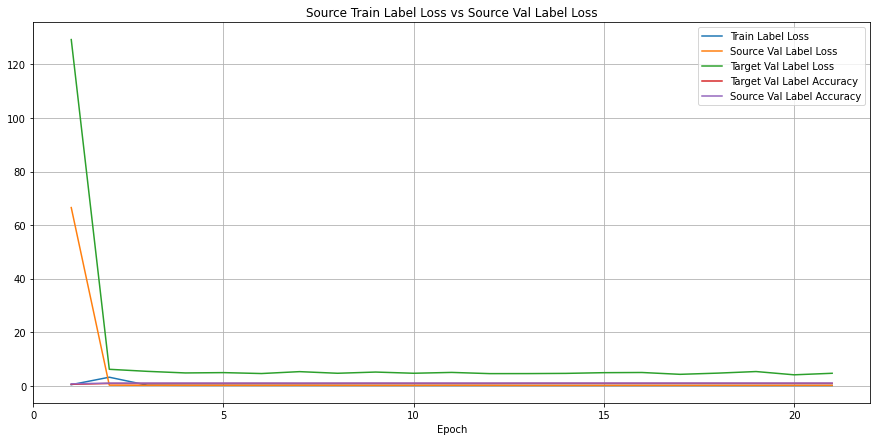

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

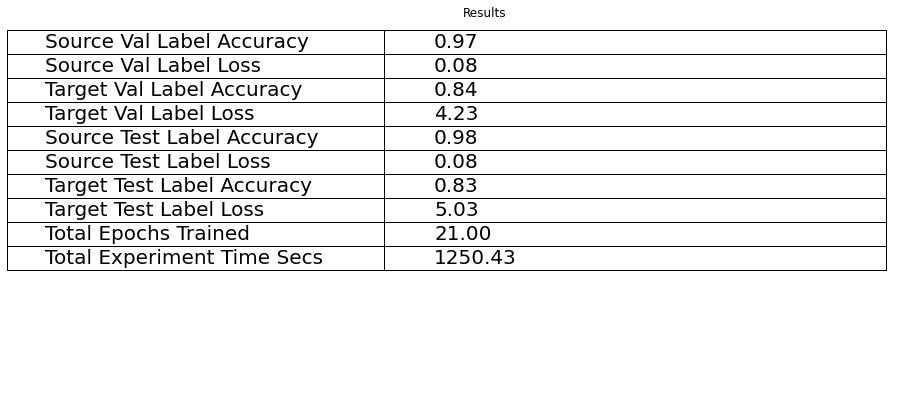

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

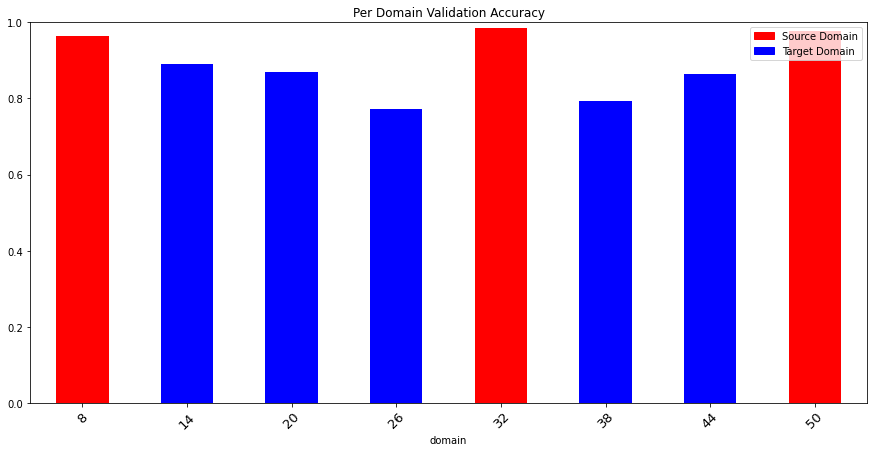

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.97578125 Target Test Label Accuracy: 0.8333854166666667
Source Val Label Accuracy: 0.9748263888888888 Target Val Label Accuracy: 0.8380729166666666


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run2.framed", "parameters": {"experiment_name": "tuned_1v2:oracle.run2.framed", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"clas